In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import math

import DDS_CMpack as CM

%matplotlib inline

data_dir = '/Users/dengdingshan/Documents/GitHub/dds_python/Summer2018/data/'

# Step1 解t0时刻的位置和速度

In [121]:
position_fram = pd.read_csv(data_dir + 'Asteroid.csv')
observe_times = len(position_fram)

In [122]:
# 常数表
R_earth = 6378.137e3 #meters
au = 149597870700 #meters

r_earth_sun = 1*au

### unit for time -> asteroid
time_unit_day = 58.1324409 # Mean solar day
time_unit = time_unit_day * 3600*24# SI 

J2000 = 2451545.0 # days

### from tdt(tt) to utc: utc = tdt(tt) + delta_tt2utc

delta_tdt2utc = -0.0039 - 32.184 # SI

# tt = tai + 32.184
# ut = tai - 0.0039 => tai = ut + 0.0039
# ut = tt - 32.184 - 0.0039 # SI

### headers index: Numbers lambda Rcos_fai Rsin_fai month day alpha delta

lam = position_fram['lambda']
Rcos_phi = position_fram['Rcos_phi']
Rsin_phi = position_fram['Rsin_phi']

alpha = position_fram['alpha']
delta = position_fram['delta']
year = 1998*np.ones(observe_times)
month = position_fram['month']
days = position_fram['day']
UT1_hours = 0*np.ones(observe_times)

In [123]:
## 假设此处已经知道我们需要计算的t0的时间具体是多少

t0_SG,t0_jd = CM.UTC2SG(1998,12,4,0)
t0_jd_s = t0_jd * 24*3600

In [124]:
####################################
# add JD and SG to Asteriod_fram
Asteriod_fram = position_fram
SG_t = []; SG_d_t = []; jd_t = []; jd_s_t = []

for i in range(len(Asteriod_fram)):
    year_int = int(year[i])
    month_int = Asteriod_fram.loc[i,'month']
    day_hour = Asteriod_fram.loc[i,'day']
    day_int = int(day_hour)
    hours = (day_hour - day_int)*24
    SG,jd = CM.UTC2SG(int(year[i]),month_int,day_int,hours)
    
    SG_t.append(SG); jd_t.append(jd)
    SG_d_t.append(SG%(3600*24)/(3600*24)*360)
    jd_s_t.append( (jd)*24*3600 )
    
Asteriod_fram_right = pd.DataFrame({'SG':np.array(SG_t),'SG_d':np.array(SG_d_t),
                                    'jd':np.array(jd_t),'jd_s':np.array(jd_s_t)})

Asteriod_fram_fil = pd.concat([Asteriod_fram,Asteriod_fram_right],axis = 1)
Asteriod_fram_fil['delta_T_s'] = Asteriod_fram_fil['jd_s'] - t0_jd_s
Asteriod_fram_fil['delta_T_unit'] = Asteriod_fram_fil['delta_T_s']/time_unit

In [125]:
## 我们需要先获得在观测时间内（1998年11月25日 至 12月6日）的太阳位置——需要插值
from scipy import interpolate 

####################################
# Sun's position in tdt = 0
Sun_fram = pd.read_csv(data_dir + 'Sun.csv')

# 求出地球相对于太阳的坐标（观测值归算）
# R_earth_sun
Earth_sun_fram = Sun_fram.loc[:,['month','day']]
Earth_sun_fram[['x','y','z']] = Sun_fram.loc[:,['x','y','z']]*(-1)

Earth_sun_fram['hours'] = np.ones(len(Earth_sun_fram))*delta_tdt2utc/(24*3600)

# utc,au to utc,jd,au

SG_total = [];jd_total = [];SG_d_total = [];jd_s_total = [];
for i in range(len(Earth_sun_fram)):
    year_int = int(year[i])
    SG,jd = CM.UTC2SG(year_int,Earth_sun_fram.loc[i,'month'],\
                       Earth_sun_fram.loc[i,'day'],Earth_sun_fram.loc[i,'hours'])
    SG_total.append(SG)
    SG_d_total.append(SG%(3600*24)/(3600*24)*360)
    jd_total.append(jd)
    jd_s_total.append( (jd)*24*3600 )

Earth_sun_fram_right = pd.DataFrame({'SG':np.array(SG_total),
                                     'SG_d':np.array(SG_d_total),
                                     'jd':np.array(jd_total),
                                    'jd_s':np.array(jd_s_total)})

Earth_sun_fram_fil = pd.concat([Earth_sun_fram,Earth_sun_fram_right],axis=1)

####################################
# 插值获得所有太阳坐标

# from scipy import interpolate 

# x,y,z三个方向分别独立插值 -- 因为运动的独立性，所以可以直接分开用样条插值

axis = ['x','y','z']
xyz_bspline = []
for ax in axis:
    y = Earth_sun_fram_fil[ax]
    x = (Earth_sun_fram_fil['jd_s'].values - t0_jd_s)/time_unit
    
    x_new = Asteriod_fram_fil['delta_T_unit'].values
    
    f_linear = interpolate.interp1d(x, y, kind='cubic')
    
#     tck = interpolate.splrep(x, y)
#     y_bspline = interpolate.splev(x_new, tck) # 插值得到的太阳相对于地球的xyz坐标

    y_bspline = f_linear(x_new)
    
    xyz_bspline.append(y_bspline)

XYZ_fram = pd.DataFrame({'X_e_s':xyz_bspline[0],
                       'Y_e_s':xyz_bspline[1],
                       'Z_e_s':xyz_bspline[2]})


Earth_sun_fram_bspline = pd.concat([XYZ_fram,Asteriod_fram_fil[['delta_T_s','delta_T_unit','jd']]],axis=1)

#################################################################
### 此处插值不同，最终会得到截然不同的结果，这可能源于计算上面有一些误差 ###
#################################################################

In [126]:
Earth_sun_fram_bspline

,X_e_s,Y_e_s,Z_e_s,delta_T_s,delta_T_unit,jd
0,0.308215,0.858946,0.372404,11691.648,0.002328,-393.363937
1,0.308049,0.858995,0.372426,12557.376,0.002500,-393.353917
2,0.292221,0.863505,0.374381,94645.152,0.018844,-392.403827
3,0.292167,0.863520,0.374387,94925.952,0.018900,-392.400577
4,0.320908,0.855136,0.370753,-54463.104,-0.010844,-394.129617
5,0.320856,0.855152,0.370760,-54192.672,-0.010790,-394.126487
6,0.320681,0.855206,0.370783,-53275.968,-0.010607,-394.115877
7,0.320629,0.855222,0.370790,-53007.264,-0.010554,-394.112767
8,0.320454,0.855276,0.370813,-52093.152,-0.010372,-394.102187
9,0.304287,0.860091,0.372901,32108.832,0.006393,-393.127627


In [127]:
# 进行拉普拉斯方法所需要的星表归算——给出最终所需要的P,Q

P = []
Q = []
Lambda_all = []
Niu_all = []
Miu_all = []
station_sun = []
X_all = [];Y_all = [];Z_all = []

for i in range(observe_times):    
    # 现求出测站相对于太阳的坐标(au为单位)
    
    # 需要根据alpha和delta求出所需的测站到地心的RA(u),DEC(v)
    # 实际上不用求v——(星表中自带了R*sin/cos phi')

    RA_station_earth = Asteriod_fram_fil.loc[i,'SG_d'] + Asteriod_fram_fil.loc[i,'lambda']
    u = np.deg2rad(RA_station_earth)

    # 加号前面的是测站到地心的矢量，加上地心到日心的矢量，即可求的测站到日心的矢量

    X = np.cos(u)*Asteriod_fram_fil.loc[i,'Rcos_phi']*R_earth/au + Earth_sun_fram_bspline.loc[i,'X_e_s']
    Y = np.sin(u)*Asteriod_fram_fil.loc[i,'Rcos_phi']*R_earth/au + Earth_sun_fram_bspline.loc[i,'Y_e_s']
    Z = Asteriod_fram_fil.loc[i,'Rsin_phi']*R_earth/au + Earth_sun_fram_bspline.loc[i,'Z_e_s']

    station_sun.append([X,Y,Z])
    X_all.append(X);
    Y_all.append(Y);
    Z_all.append(Z)
    
    # 再根据测站到日心的位置最终算出Pj,Qj
    delta_rad = np.deg2rad(delta[i])
    alpha_rad = np.deg2rad(alpha[i])
    
    Lambda = np.cos(delta_rad)*np.cos(alpha_rad)
    Miu = np.cos(delta_rad)*np.sin(alpha_rad)
    Niu = np.sin(delta_rad)
    Lambda_all.append(Lambda)
    Miu_all.append(Miu)
    Niu_all.append(Niu)
    
    P_j = Niu*X - Lambda*Z
    Q_j = Niu*Y - Miu*Z
    
    P.append(P_j);Q.append(Q_j)

PF_fill = position_fram
PF_fill['P'] = np.array(P)
PF_fill['Q'] = np.array(Q)
PF_fill['Lambda'] = np.array(Lambda_all)
PF_fill['Miu'] = np.array(Miu_all)
PF_fill['Niu'] = np.array(Niu_all)
PF_fill['X'] = np.array(X_all)
PF_fill['Y'] = np.array(Y_all)
PF_fill['Z'] = np.array(Z_all)

# 为了避免和底下计算轨道根数时用到的P,Q（坐标轴指向）产生冲突，此处将P,Q重新命名为Pj,Qj以便使用
Pj = P; Qj = Q

In [128]:
# 使用unix时间戳标记拥有的时间单位，并且计算时间间隔

# t0的值要预先给定
t0 = datetime.datetime.strptime("1998-12-4 0:0:0","%Y-%m-%d %H:%M:%S")
unix_t0 = time.mktime(t0.timetuple())

# 用unix时间戳计算
unix_T = []
for i in range(observe_times):
    day_int = math.floor(days[i])
    day_plus = days[i] - day_int
    Date_str = str(int(year[i])) +'-'+ str(month[i]) +'-'+ str(day_int)
    Date = datetime.datetime.strptime(Date_str,"%Y-%m-%d")
    unix_Date = time.mktime(Date.timetuple())
    unix_T.append(unix_Date + day_plus*3600*24) # unix时间戳起点为1971年，所以此处多余的时间用加法
    
# 给定所需要的按照理论单位的时间值
T = (np.array(unix_T) - unix_t0)/time_unit
F0 = np.ones(observe_times).tolist()
G0 = T.tolist()

In [129]:
PF_fill['delta_T_unit'] = T
# PF_fill

In [130]:
def F_expansion(r,v,t):
    s = np.dot(r,v)
    u = 1/r
    
    Out = 1 - 0.5*(u**3)*(t**2) + 0.5*(u**5)*s*(t**3) + 1/24*(u**5)*(3*(v**2) - 2*u - 15*(u**2)*(s**2))
    return Out

def G_expansion(r,v,t):
    s = np.dot(r,v)
    u = 1/r
    
    Out = t - 1/6*(u**3)*(t**3) + 1/4*(u**5)*s*(t**4) + 1/120*(u**5)*(9*(v**2) - 8*u -45*(u**2)*(s**2))*(t**5)
    return Out

In [131]:
list(np.arange(3,22))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [132]:
# 选定用于归算轨道六根数的数据点（观测序数）
# Ob_index = [i for i in range(observe_times)] # if i != 6]
# Ob_index = [0,1,2]
# Ob_index = [i for i in range(observe_times) if i not in [1,2,22,23,24,25,26,27,28,29,30,31,32,\
#                                                          33,34,35,36,37,38,39]]
Ob_index = [0,1] + list(np.arange(3,22))

############################################

# Laplace循环长数值和初值
F = [ F0[i] for i in Ob_index ]
G = [ G0[i] for i in Ob_index ]
Niu = Niu_all
Miu = Miu_all
Lambda = Lambda_all

# Laplace循环
Nwind = 0
key = 0
while key == 0:
    A = []
    b = []
    nwind = 0 # 用于索引循环中的F,G的list
    # 构造系数矩阵和常数阵
    for j in Ob_index:
        
        A.append([Niu[j]*F[nwind],0,-Lambda[j]*F[nwind],Niu[j]*G[nwind],0,-Lambda[j]*G[nwind]])
        A.append([0,Niu[j]*F[nwind],-Miu[j]*F[nwind],0,Niu[j]*G[nwind],-Miu[j]*G[nwind]])
        b.append(Pj[j])
        b.append(Qj[j])
        
        nwind += 1
    
    AA = np.array(A)
    b = np.array(b)
    
    # 解出r0和V0
    ans = np.linalg.solve(np.dot(AA.T.copy(),AA),np.dot(AA.T.copy(),b))
#     ans=np.linalg.lstsq(AA,b)

#     r0=ans[0].T[0][0:3]
#     v0=ans[0].T[0][3:6]
    r0 = ans[:3]
    v0 = ans[3:]
#     print(r0,v0)
    # 用r0和v0求出新的F和G
    norm_r0 = np.sqrt(np.dot(r0,r0))
    norm_v0 = np.sqrt(np.dot(v0,v0))
    
    F_old = F; G_old = G
    F = [];G = []
    for k in Ob_index:
        F.append(CM.F(norm_r0,norm_v0,T[k]))
        G.append(CM.G(norm_r0,norm_v0,T[k]))
        
    # 上述循环完成，计数一次
    Nwind += 1
    
    # 判断是否跳出循环
    # 取F,G的二范数的最大值判断是否小于我们所需的精度
    delta_F = np.linalg.norm(np.array(F) - np.array(F_old), 2)
    delta_G = np.linalg.norm(np.array(G) - np.array(G_old), 2)
#     delta_F = np.abs(np.max(np.array(F) - np.array(F_old)))
#     delta_G = np.abs(np.max(np.array(G) - np.array(G_old)))
    biggest = np.max([delta_F,delta_G])

    if biggest < 1e-13:
        print('end: ',int(Nwind))
        print(r0,v0)
        key = 1
    elif Nwind > 1e4:
        print('Nan')
        print(norm_r0,norm_v0)
        key = 1

end:  9
[0.31208374 0.8586286  0.37274055] [-0.84395568  0.30872163  0.1682443 ]


In [133]:
print(r0,'r0:',norm_r0*au,'km = ',norm_r0,'au;')

print(v0,'v0:',norm_v0*au/1e3/time_unit,'km/s =',norm_v0,'au/[T];')

# print(t0*time_unit,'s')

[0.31208374 0.8586286  0.37274055] r0: 147608064704.78757 km =  0.9866989684685905 au;
[-0.84395568  0.30872163  0.1682443 ] v0: 27.23103442102248 km/s = 0.9142627557765267 au/[T];


# Step 2 解轨道六根数

In [134]:
# # 取轨国际单位制的常数表

# R_earth = 6371e3 # m

# M_earth = 5.965e24 # kg
# G_graviation = 6.672e-11 # N·m^2 /kg^2 

# au = 149597870e3 # m
# r_station_earth = 0.999102 #*R_earth
# r_earth_sun = 1*au

# # time_unit = 806.81163 #806.8116 # SI 

# # miu_GM = 398600.5e-6 # km^3/SI^2

# miu_GM = G_graviation*M_earth # m^3/SI^2

## 还是先继续使用已经在使用的理论单位！

miu_GM = 1

In [135]:
# rg = r0*R_earth
# norm_rg = np.sqrt(np.dot(rg,rg))
# vg = v0*R_earth/time_unit
# norm_vg = np.sqrt(np.dot(vg,vg))
# tg = t0*time_unit

rg = r0
norm_rg = np.sqrt(rg.dot(rg))
vg = v0
norm_vg = np.sqrt(vg.dot(vg))

In [136]:
a = (2/norm_rg - (norm_vg**2)/miu_GM)**(-1)
a

0.8395711502720818

In [137]:
n = np.sqrt(miu_GM/(a**3))
n

1.2999113623744878

In [138]:
e = np.sqrt( (1 - norm_rg/a)**2 + (rg.dot(vg) / (n*a**2))**2)
e

0.18881227379336252

In [139]:
cos_E = (1 - norm_rg/a)/e
sin_E = (rg.dot(vg) / ((a**2)*n))/e
E = math.atan2(sin_E,cos_E)

E

2.760143851834918

In [140]:
M = E - e*math.sin(E)

In [141]:
P = (cos_E/norm_rg)*rg - (sin_E/(a*n))*vg
Q = (sin_E/(norm_rg)*np.sqrt(1-e**2))*rg + ((cos_E - e)/(a*n*np.sqrt(1-e**2)))*vg
R = np.cross(P,Q)
P,Q

(array([-0.00568455, -0.91296337, -0.40800194]),
 array([ 0.99517593, -0.00362211, -0.03724053]))

In [142]:
pz = P[2]; qz = Q[2]
tan_w_raw = pz/qz
if pz >=0 and qz >= 0:
    # w I
    w = math.atan(tan_w_raw)
elif pz >= 0 and qz < 0:
    # w II
    w = math.atan(tan_w_raw) + np.pi
elif pz < 0 and qz < 0:
    # w III
    w = math.atan(tan_w_raw) + np.pi
elif pz < 0 and qz >= 0:
    # w IV
    w = math.atan(tan_w_raw) + 2*np.pi

In [143]:
h = np.cross(rg,vg)
norm_h = np.sqrt(np.dot(h,h))

h_A, h_B, h_C = h[0:3]

# get cos_i, sin_i
cos_i = (h_C/norm_h)
tan_i = np.sqrt(h_A**2 + h_B**2) / h_C

sin_i = tan_i*cos_i

# get cos_\sin_Omega
sin_Omega = h_A/(norm_h*sin_i)
cos_Omega = -h_B/(norm_h*sin_i)

i_fin = math.atan2(sin_i,cos_i)
Omega = math.atan2(sin_Omega,cos_Omega)

In [144]:
print(a,e,M,i_fin,Omega,w)

0.8395711502720818 0.18881227379336252 2.689855550545528 0.421648918040238 0.07988324979666395 4.621365830133341


In [145]:
np.rad2deg([M,i_fin,Omega,w])

array([154.11737055,  24.15870344,   4.57697307, 264.78475765])

# Step 3 反算星历表


In [146]:
t3 = 0
T3 = Asteriod_fram_fil['delta_T_unit']

In [148]:
M_total = M + n*T3

In [149]:
# 迭代 开普勒方程解 E
E_total = []
for i in range(len(M_total)):
    epsilon = 1e-10
    key = 0
    En0 = M_total[i]
    
    En_new = En0
    while key == 0:
        En_old = En_new
        En_new = En_old - (En_old - M_total[i] - e*np.sin(En_old))/(1-e*np.cos(En_old))
        delta_En = np.abs(En_new - En_old)

        if delta_En < epsilon:
            key = 1;

    E_total.append(En_new)

In [150]:
# 计算新的 P,Q 

P_new = np.array([np.cos(Omega)*np.cos(w) - np.sin(Omega)*np.sin(w)*np.cos(i_fin),\
                 np.sin(Omega)*np.cos(w) + np.cos(Omega)*np.sin(w)*np.cos(i_fin),\
                 np.sin(w)*np.sin(i_fin)])
Q_new = np.array([-np.cos(Omega)*np.sin(w) - np.sin(Omega)*np.cos(w)*np.cos(i_fin),\
                 -np.sin(Omega)*np.sin(w) + np.cos(Omega)*np.cos(w)*np.cos(i_fin),\
                 np.cos(w)*np.sin(i_fin)])

### 新算出来的P_new,Q_new有误！
P_new,Q_new

(array([-0.01809985, -0.91299401, -0.40757125]),
 array([ 0.99930266, -0.00320383, -0.03720122]))

In [151]:
P,Q

(array([-0.00568455, -0.91296337, -0.40800194]),
 array([ 0.99517593, -0.00362211, -0.03724053]))

In [152]:
# 计算新的 r,v
Rt = [];Vt = []
for Et in E_total:
    rt = a*(np.cos(Et) - e)*P_new + a*np.sqrt(1 - e**2)*np.sin(Et)*Q_new
    rt_norm = np.sqrt( np.dot(rt,rt) )

    vt = -a**2*n/rt_norm*np.sin(Et)*P_new + a**2*n/rt_norm*np.sqrt(1 - e**2)*np.cos(Et)*Q_new
    vt_norm = np.sqrt( np.dot(vt,vt) )

    L_rt = rt/ np.sqrt( np.dot(rt,rt))

#     print(rt_norm,vt_norm)
    
    Rt.append(rt)
    Vt.append(vt)

In [154]:
# 归算最终的赤经赤纬
# 先获得方向矢量L，再从L归算预测的alpha和delta值
P_sun = Rt
P_station = []
L_forecast_total = []

for j in range(observe_times):
    earth_sun = np.array([PF_fill.loc[j,'X'],PF_fill.loc[j,'Y'],PF_fill.loc[j,'Z']])
    P_station = np.array(P_sun[j] - earth_sun)
    L_forecast = np.true_divide(P_station,np.linalg.norm(P_station,2))
    L_forecast_total.append(L_forecast)

L_fa = np.array(L_forecast_total)

L_fa

array([[ 0.97173534, -0.21855387, -0.08924482],
       [ 0.97199552, -0.21768988, -0.08852022],
       [ 0.98692859, -0.15873289, -0.02785381],
       [ 0.9869697 , -0.15850929, -0.02766981],
       [ 0.94842061, -0.27909558, -0.15034626],
       [ 0.94855582, -0.278787  , -0.1500655 ],
       [ 0.94901317, -0.27773774, -0.1491166 ],
       [ 0.94914691, -0.2774293 , -0.14883928],
       [ 0.94960073, -0.27637736, -0.14789866],
       [ 0.97635659, -0.20359515, -0.07264177],
       [ 0.97655896, -0.20285273, -0.07199556],
       [ 0.97662505, -0.20260914, -0.07178475],
       [ 0.97669237, -0.20236041, -0.07157008],
       [ 0.97675986, -0.20211049, -0.07135496],
       [ 0.96895823, -0.22714296, -0.09760133],
       [ 0.96899368, -0.22703646, -0.09749716],
       [ 0.96902039, -0.22695614, -0.09741868],
       [ 0.96905505, -0.22685179, -0.09731685],
       [ 0.97789002, -0.19786608, -0.06767657],
       [ 0.97814903, -0.19687739, -0.06681143],
       [ 0.97840309, -0.19589873, -0.065

In [155]:
# 计算delta 和alpha
# delta in [-180,180]
Delta_forecast = np.rad2deg(np.arcsin(L_fa[:,2]))

# alpha in [0,360]
Alpha_forecast_raw = np.rad2deg(np.arctan2(L_fa[:,1],L_fa[:,0]))
Alpha_forecast = []
for alpha_single in Alpha_forecast_raw:
    if alpha_single > 0:
        Alpha_forecast.append(alpha_single)
    else:
        Alpha_forecast.append(360 + alpha_single)
    
Alpha_forecast = np.array(Alpha_forecast)

# Step 4 计算残差数据

In [156]:
delta_AlphaCosDelta = Alpha_forecast*np.cos(np.deg2rad(Delta_forecast)) \
                    - PF_fill['alpha']*np.cos(np.deg2rad(PF_fill['delta']))
delta_Delta = Delta_forecast - PF_fill['delta']

pd.DataFrame({'$ \Delta a\cos\delta $': np.array(delta_AlphaCosDelta),
             '$ \Delta\delta $ ':np.array(delta_Delta)})

,$ \Delta a\cos\delta $,$ \Delta\delta $
0,335.619846,-24.820164
1,335.693429,-24.778482
2,340.370207,-21.379445
3,340.384879,-21.368898
4,329.407395,-28.272076
5,329.441085,-28.256306
6,329.561513,-28.302403
7,329.588451,-28.186667
8,329.701713,-28.132976
9,336.973315,-23.890347


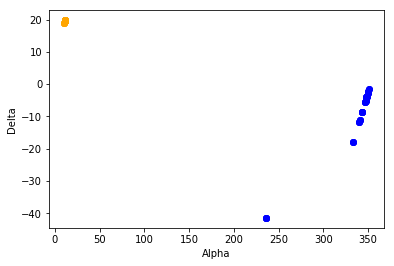

In [157]:
plt.figure()

plt.xlabel('Alpha')
plt.ylabel('Delta')

plt.scatter(PF_fill['alpha'],PF_fill['delta'],c = 'orange')
plt.scatter(Alpha_forecast,Delta_forecast,c = 'b')

plt.show()

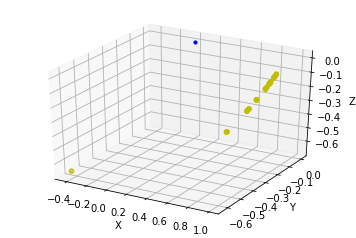

In [158]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
#  将数据点分成三部分画，在颜色上有区分度
ax.scatter(L_fa[:,0], L_fa[:,1], L_fa[:,2], c='y')  # 绘制数据点
ax.scatter(0,0,0,c= 'b',s = 10)

ax.set_zlabel('Z')  # 坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()